In [1]:
from dataset_nuscenes import DepthDatasetNuscenes
from model import RadarCamModel
from loss import custom_loss

import torch
from torch.utils.data import DataLoader
import numpy as np

from loss import custom_loss, depth_loss
from plotting import draw_result, draw_error_map

import matplotlib.pyplot as plt
import time

from tqdm import tqdm

In [2]:
# DATASET PARAMETERS
DIR_DATA = '/ssd/Datasets_and_code/nuscenes_depth_estimation/dataset/dataset_radar_cam' # Root to the folder with the prepared data
W_RESIZED = 800 #800 # If 0, the image is not resized in width
H_RESIZED = 450 #450 # If 0, the image is not resized in height
MIN_DIST = 0.0 # Threshold minimum depth to discard points
MAX_DIST = 50.0 # Threshold maximum depth to discard points
NUMBER_RADAR_POINTS = 100 # Number of radar points to use. If the number of points in a sample is less than this, they are 
                          # resampled randomly to create an array of fixed number of points. This shouldn't hurt the performance

# MODEL PARAMETERS
BATCH_SIZE = 1
RADAR_CHANNELS_ENCODER = [64, 128, 256, 432] 
UNET_CHANNELS_IMG = [2, 4, 8, 12, 16, 24, 32, 48] 
UNET_CHANNELS_RADAR = 24

# TRAINING PARAMETERS
L2_LIDAR = False
ALPHA_LOSS = 1.0
BETA_LOSS = 5.0
GAMMA_LOSS = 0.1
POWER_CONSISTENCY = 5.0
LEARNING_RATE = 0.001
NUM_EPOCHS = 15
NUMBER_SAMPLES_PLOT = 3
MODEL_PATH = 'results/2024-06-21_23-46-23/model_8.pth'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: ", device)

test_set = DepthDatasetNuscenes("test", DIR_DATA, W_RESIZED, H_RESIZED, MIN_DIST, MAX_DIST, NUMBER_RADAR_POINTS)
dataloader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle=True)

model = RadarCamModel(RADAR_CHANNELS_ENCODER, UNET_CHANNELS_IMG, UNET_CHANNELS_RADAR).to(device)
model.eval()
model.load_state_dict(torch.load(MODEL_PATH))

Using device:  cuda


<All keys matched successfully>

  0%|                                               | 0/41 [00:00<?, ?it/s]

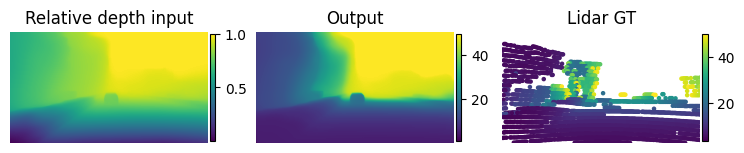

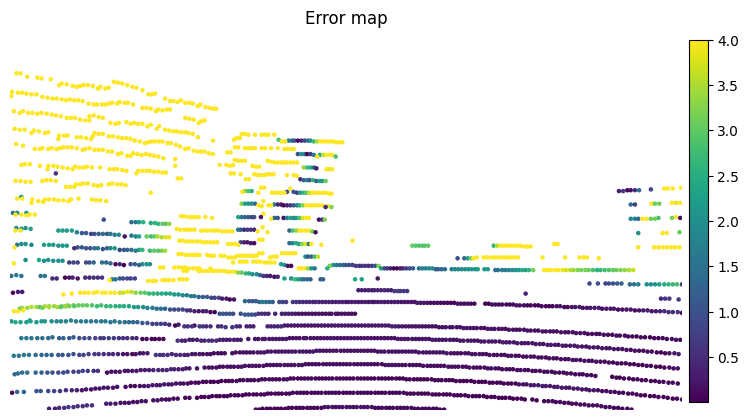

100%|██████████████████████████████████████| 41/41 [00:30<00:00,  1.35it/s]

Loss NN total: 0.05869046244315985, loss NN lidar: 0.043309045274083205, loss NN smoothness: 0.000408157472720188,          loss NN consistency: 0.13340629728102102, mean inference time PER BATCH: 87.2461388750774 ms


In [4]:
test_loss = 0.0
test_loss_lidar = 0.0
test_loss_smoothness = 0.0
test_loss_consistency = 0.0

inference_time = 0.0

with torch.no_grad():
    for batch_idx, (sample_token, rel_depth, radar, lidar) in enumerate(tqdm(dataloader)):
        rel_depth, radar, lidar = rel_depth.to(device, dtype=torch.float), radar.to(device, dtype=torch.float), lidar.to(device, dtype=torch.float)
        
        init_time = time.time()
        outputs = model(rel_depth, radar)
        end_time = time.time()
        inference_time += (end_time-init_time)*1000.0

        loss = custom_loss(outputs, lidar, rel_depth, l2_lidar=L2_LIDAR, alpha=ALPHA_LOSS, beta=BETA_LOSS, gamma=GAMMA_LOSS, power_consistency=POWER_CONSISTENCY)
        lidar_loss, lidar_loss_errormaps = depth_loss(outputs, lidar, l2_lidar=L2_LIDAR)
        
        test_loss += loss[0].item()
        test_loss_lidar += loss[1].item()
        test_loss_smoothness += loss[2].item()
        test_loss_consistency += loss[3].item()
        
        
        if NUMBER_SAMPLES_PLOT !=0 and batch_idx == 0:
            rel_depth = rel_depth.cpu()[:NUMBER_SAMPLES_PLOT,:, :, :]
            lidar = lidar.cpu()[:NUMBER_SAMPLES_PLOT,:, :, :]
            outputs = outputs.cpu()[:NUMBER_SAMPLES_PLOT,:, :, :]
            error_maps = lidar_loss_errormaps.cpu()[:NUMBER_SAMPLES_PLOT,:,:,:]*50.0
            draw_result(rel_depth, outputs, lidar, MIN_DIST, MAX_DIST)
            draw_error_map([error_maps], clip_error=4, 
                            dot_size=5, names = ["Error map"])
            
        
    test_loss /= len(dataloader)
    test_loss_lidar /= len(dataloader)
    test_loss_smoothness /= len(dataloader)
    test_loss_consistency/= len(dataloader)
    inference_time /= float(len(dataloader))
    
    print(f"Loss NN total: {test_loss}, loss NN lidar: {test_loss_lidar}, loss NN smoothness: {test_loss_smoothness},\
          loss NN consistency: {test_loss_consistency}, mean inference time PER BATCH: {inference_time} ms")